Now let's make these Autoencoders 'VARIATIONAL'

The trick is to add a 'sampling' layer



In [3]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K

def create_VAE(input_dim,intermediate_dim=256,latent_dim=2):
    
    # Encoder Model
    inputs    = Input(shape=(input_dim,))
    x         = Dense(intermediate_dim, activation='linear')(inputs)
    
    # Two branches for mean and var
    z_mean    = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # -------------------------------------------------------------------------------------
    # Sampling layer --> the bit that makes it variational
    # First define the sampling function (it can also be defined outside of this code)
    def sampling(args):
        mean, log_var = args
        batch   = K.shape(mean)[0]
        dim     = K.int_shape(mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return mean + K.exp(0.5 * log_var) * epsilon

    # Then use it in a Layer (Lambda is like a user-defined layer)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    # -------------------------------------------------------------------------------------
    
    # Notice here how I have three outputs
    encoder   = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder model
    latent_inputs = Input(shape=(latent_dim,))
    x             = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs       = Dense(input_dim, activation='sigmoid')(x)
    
    decoder       = Model(latent_inputs, outputs, name='decoder')
    
    # instantiate VAE model
    # Takes the third ouput of the encoder (the sampled Z)
    outputs = decoder(encoder(inputs)[2])
    
    # Keep the mean and var outputs explicit so we can use them in the loss function
    vae = Model(inputs, [outputs,z_mean,z_log_var], name='vae')

    return vae,encoder,decoder



Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)




Ok.  We still need a loss function.  In fact, we need two loss functions, one for the data fitting term (mean squared error like before), one for the distributional prior of Z, which says the distribution is a priori normal N(0,1). 

Here I have split this into three loss functions


In [4]:


from keras.losses import mse

def recon_loss(inputs,outputs):
    loss = mse(inputs, outputs)
    
    return K.mean(loss)


# Recall the two losses below combined are just the 
# KL divergence of a Gaussian(mu,var) from a Normal(0,1)
def mean_loss(target,z_mean):

    loss = 1 - K.square(z_mean)
    loss = K.sum(loss, axis=-1)
    loss *= -0.5
    
    return K.mean(loss)

def var_loss(target,z_log_var):

    loss = z_log_var - K.exp(z_log_var)
    loss = K.sum(loss, axis=-1)
    loss *= -0.5
    
    return K.mean(loss)




Ok now we have a model and three losses, let's get the MNIST data again.

BELOW I JUST COPIED THE STUFF FROM PART2 TO GET MNIST AND PLOTTING FUNCTION

In [5]:

import numpy as np
data = np.load('/Users/saad/Downloads/mnist.npz')

# Training/Testing data
X_train = data['x_train']
X_test  = data['x_test']

# Vectorise images (28x28 -> 784)
image_size  = X_train.shape[1]
input_dim   = image_size * image_size
X_train     = np.reshape(X_train, [-1, input_dim])
X_test      = np.reshape(X_test, [-1, input_dim])

# Rescale between 0 and 1
X_train     = X_train / 255.0
X_test      = X_test  / 255.0

# display a nxn grid of images
import matplotlib.pyplot as plt
def gridplot(X,im_size,n=10):

    pad_size = 5
    figure = np.zeros((pad_size + (im_size+pad_size) * n, 
                       pad_size + (im_size+pad_size) * n))

    cnt = 0
    ii = pad_size
    for i in range(n):
        jj = pad_size 
        for j in range(n):
            if(cnt<X.shape[0]):                
                image = np.reshape(X[cnt,...],(im_size,im_size))
                figure[ii:ii+im_size,jj:jj+im_size] = image
            
            jj += (im_size+pad_size)
            cnt += 1
            
        ii += (im_size+pad_size)
        
    plt.figure(figsize=(10, 10))
    plt.imshow(figure)
    plt.show()



In [6]:

# Create the Variational Autoencoder (don't bother counting the number of parameters)
vae,enc,dec = create_VAE(input_dim=X_train.shape[1],latent_dim=2)
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 201988      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          202256      encoder[1][2]                    
__________________________________________________________________________________________________
z_mean (De

The clever bit below is to have a mixture of losses that together define the prior on the distribution of the latent variable z and the data fit (mean squared error)

Since each layer has an input and an ouput, each layer can calculate a loss function based on its input and ouput. In the definition of the model I have intentionally given names to the layers I wanted to use for calculating a loss and made their output an ouput of the model.


In [7]:
losses = {'decoder':recon_loss,
          'z_mean':mean_loss,
          'z_log_var':var_loss}

# Note here I am giving weights to the losses. 
# Each dimension of the data contributes an additional term in the loss
vae.compile(optimizer='adam',loss=losses,
            loss_weights={'decoder':X_train.shape[1],'z_mean':1.0,'z_log_var':1.0})

n = X_train.shape[0]

# The bit between {} is the target output for the loss calculation. 
# The losses for mean and logvar don't need targets, but it seems I still
#  Need to define them here and I can't just use 'None'  .... 
vae.fit(X_train,
        {'decoder':X_train,'z_mean':np.zeros((n,1)),'z_log_var':np.zeros((n,1))},
        epochs=60,            
        batch_size=128,shuffle=True)




Epoch 1/60
60000/60000 [==============================] - 5s 90us/step - loss: 55.5428 - decoder_loss: 0.0651 - z_mean_loss: 2.3052 - z_log_var_loss: 2.2132
Epoch 2/60
60000/60000 [==============================] - 5s 78us/step - loss: 45.2704 - decoder_loss: 0.0543 - z_mean_loss: 0.2017 - z_log_var_loss: 2.4682
Epoch 3/60
60000/60000 [==============================] - 5s 83us/step - loss: 44.3757 - decoder_loss: 0.0530 - z_mean_loss: 0.1503 - z_log_var_loss: 2.7055
Epoch 4/60
60000/60000 [==============================] - 5s 81us/step - loss: 44.0850 - decoder_loss: 0.0525 - z_mean_loss: 0.1205 - z_log_var_loss: 2.8306
Epoch 5/60
60000/60000 [==============================] - 5s 89us/step - loss: 43.8629 - decoder_loss: 0.0521 - z_mean_loss: 0.1240 - z_log_var_loss: 2.8996
Epoch 6/60
60000/60000 [==============================] - 5s 91us/step - loss: 43.6777 - decoder_loss: 0.0518 - z_mean_loss: 0.1278 - z_log_var_loss: 2.9420
Epoch 7/60
60000/60000 [==============================] - 

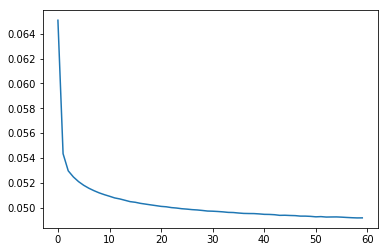

In [12]:
# Look at fitting history

import matplotlib.pyplot as plt
#plt.plot(vae.history.history['z_mean_loss'])
#plt.plot(vae.history.history['z_log_var_loss'])
plt.plot(vae.history.history['decoder_loss'])





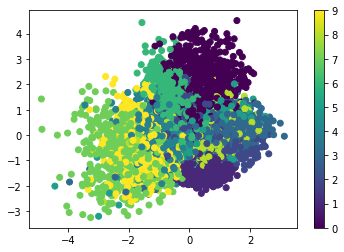

In [14]:
#  Look at embedding
zmean,_,z=enc.predict(X_test)

plt.scatter(z[:,0],z[:,1],c=data['y_test']) 
plt.colorbar()
plt.show()



Kinda looks more like a contiuum. Certainly Z stays around zero!



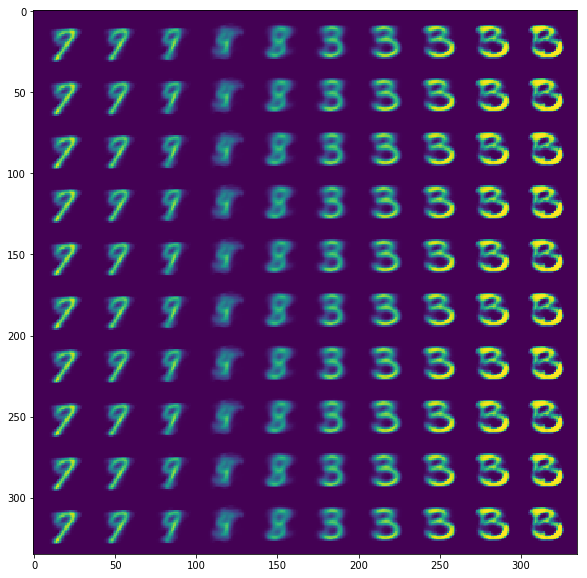

In [15]:
# Now let us 'generate' images from the lowdim space

# Grid of z samples
x   = np.linspace(-2, 4, 10)
y   = np.linspace(-2, 2, 10)
x,y = np.meshgrid(x,y)
z   = np.concatenate((x.flatten()[:,None],y.T.flatten()[:,None]),axis=1)

# Decode images
X = dec.predict(z)

# Visualise
gridplot(X,28)


As before, let's see some predictions:

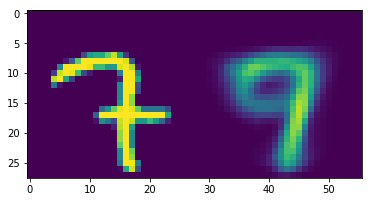

In [27]:
pred,_,_ = vae.predict(X_test)

random_index = np.random.randint(X_test.shape[0])
plt.imshow(np.concatenate((X_test[random_index,:].reshape((28,28)),
                            pred[random_index,:].reshape((28,28))),axis=1))



It's pretty bad. 


Exercises: 

- Try to add an extra cost function to the VAE that optimises classification accuracy. 

- Replace the dense layers with convolutional layers.

- Sparse autoencoder: add an activity regulariser to some of the encoding layers to get a sparse lowdim embedding (e.g. activity_regularizer=regularizers.l1(10e-5))



The End.